In [1]:
import os
import config
%matplotlib notebook 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

About to make logging dir (if nec): C:\Users\Chris\logs\stock_predictor
Setting up logging...
Creating logger config ...


c:\users\chris\workspaces\stock-predictor\venv\lib\site-packages\sklearn\utils\fixes.py:54: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
# df = pd.read_csv('../dataset/GOOG-year.csv')

file_path = os.path.join(config.constants.FINANCE_DATA_DIR, "stock-predictor-legacy-datasets", "GOOG-year.csv")
df = pd.read_csv(file_path)

date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055573,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [4]:
class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias = 0.1,
                attention_size = 10):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units = size_layer, 
                                                                    memory = self.X)
        luong_cells = tf.contrib.seq2seq.AttentionWrapper(cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], 
                                                                                           state_is_tuple = False), 
                                                        attention_mechanism = attention_mechanism,
                                                        attention_layer_size = size_layer)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(num_units = size_layer, 
                                                                    memory = self.X)
        bahdanau_cells = tf.contrib.seq2seq.AttentionWrapper(cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], 
                                                                                           state_is_tuple = False), 
                                                        attention_mechanism = attention_mechanism,
                                                        attention_layer_size = size_layer)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([bahdanau_cells,luong_cells])
        drop = tf.contrib.rnn.DropoutWrapper(self.rnn_cells, output_keep_prob = forget_bias)
        self.initial_state = self.rnn_cells.zero_state(
            dtype = tf.float32, batch_size = tf.shape(self.X)[0]
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, dtype = tf.float32, initial_state = self.initial_state
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [5]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 50

In [6]:
with tf.device('/device:GPU:0'):
    tf.reset_default_graph()
    modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)

    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.InteractiveSession(config=config)

    sess.run(tf.global_variables_initializer())

W0912 20:27:24.662119  7952 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0912 20:27:24.666113  7952 deprecation.py:506] From c:\users\chris\workspaces\stock-predictor\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0912 20:27:25.090112  7952 deprecation.py:323] From <ipython-input-4-f79d43bf4d7e>:6: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be r

In [7]:
for i in range(epoch):
    total_loss = 0
    modelnn.initial_state = modelnn.rnn_cells.zero_state(
        dtype = tf.float32, batch_size = 1
    )

    pbar = range(0, len(df_log) - 1, timestamp)
    for k in pbar:
        index = min(k + timestamp, len(df_log) - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index].values, axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        _, loss, last_state = sess.run(
            [modelnn.optimizer, modelnn.cost, modelnn.last_state],
            feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
        )
        modelnn.initial_state = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.020302831400185822
epoch: 200 avg loss: 0.0056608867750037465
epoch: 300 avg loss: 0.008670651082647965
epoch: 400 avg loss: 0.018693532270845026
epoch: 500 avg loss: 0.011620949315838515


In [8]:
modelnn.initial_state = modelnn.rnn_cells.zero_state(
    dtype = tf.float32, batch_size = 1
)
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            )
        },
    )
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits
    modelnn.initial_state = last_state

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0)},
)
modelnn.initial_state = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [9]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0)
        },
    )
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))
    modelnn.initial_state = last_state

In [10]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [15]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

<IPython.core.display.Javascript object>


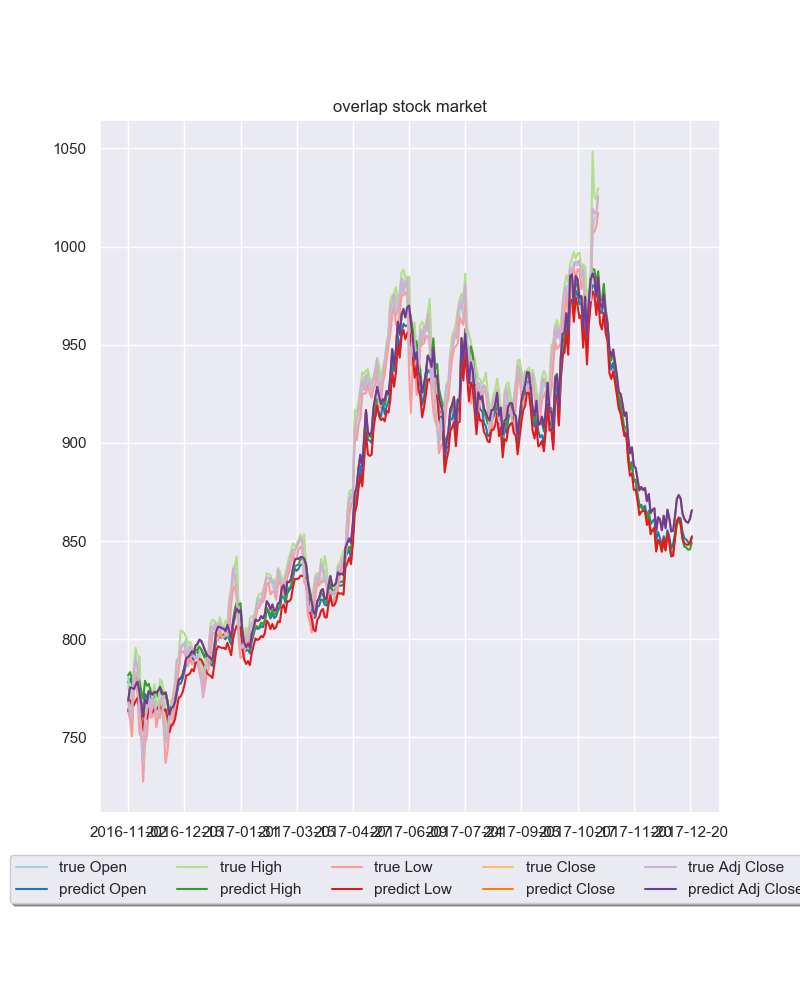

In [16]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (8, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

<IPython.core.display.Javascript object>


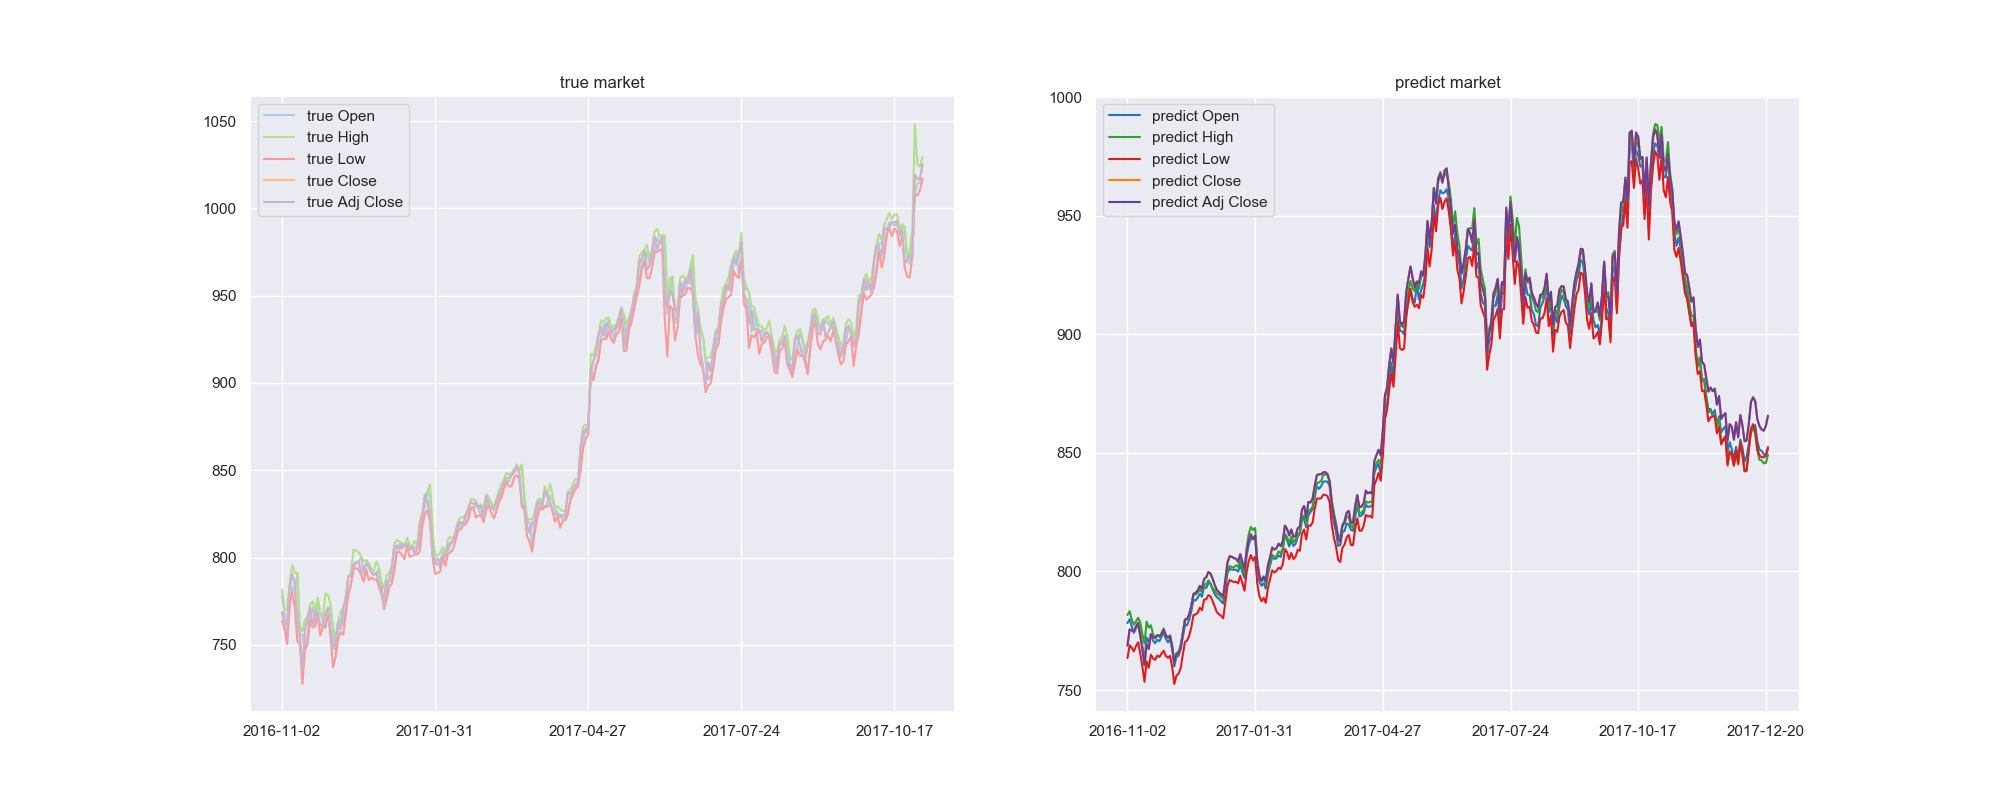

In [17]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()


<IPython.core.display.Javascript object>


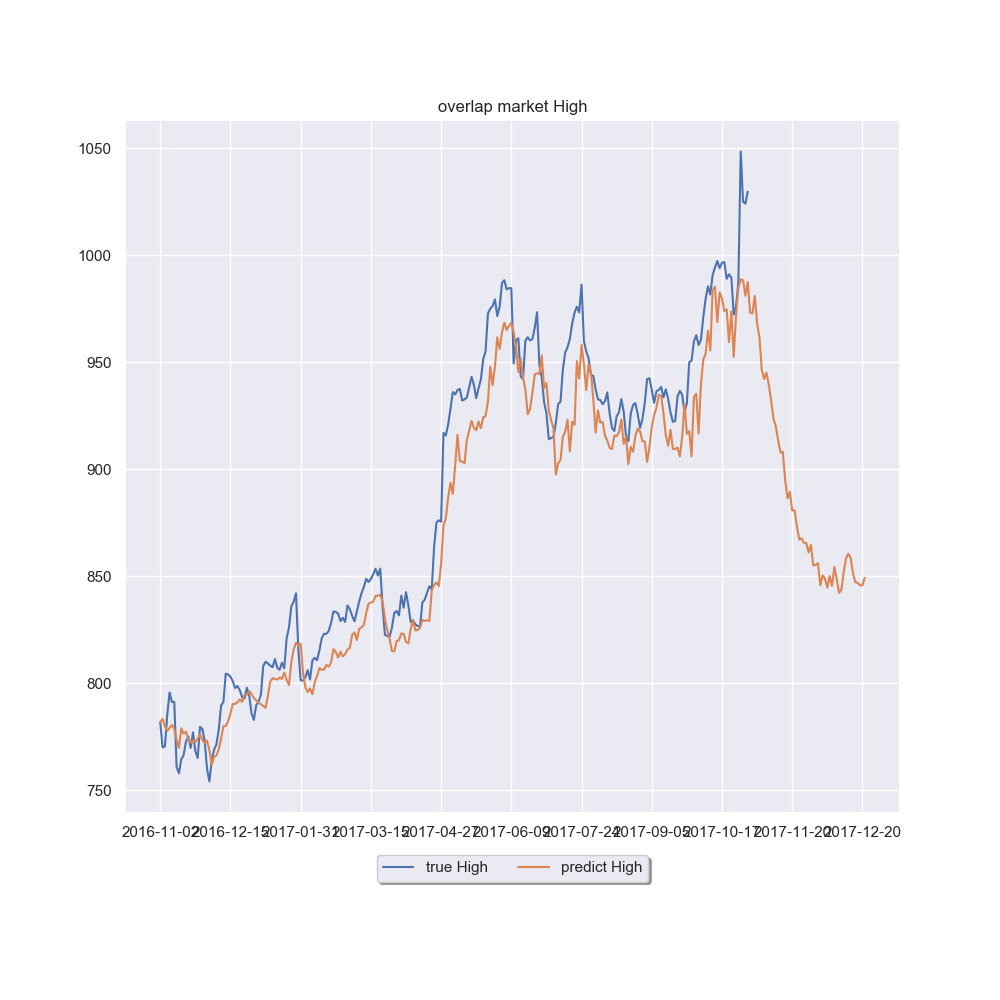

In [18]:
fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(111)
column_index = -5 # "High"
column_name = "High"
ax.plot(x_range_original, df.iloc[:, column_index], label = f"true {column_name}")
ax.plot(x_range_future, anchor(df_log[:, column_index], 0.5), label = f"predict {column_name}")
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title(f"overlap market {column_name}")
plt.show()


<IPython.core.display.Javascript object>


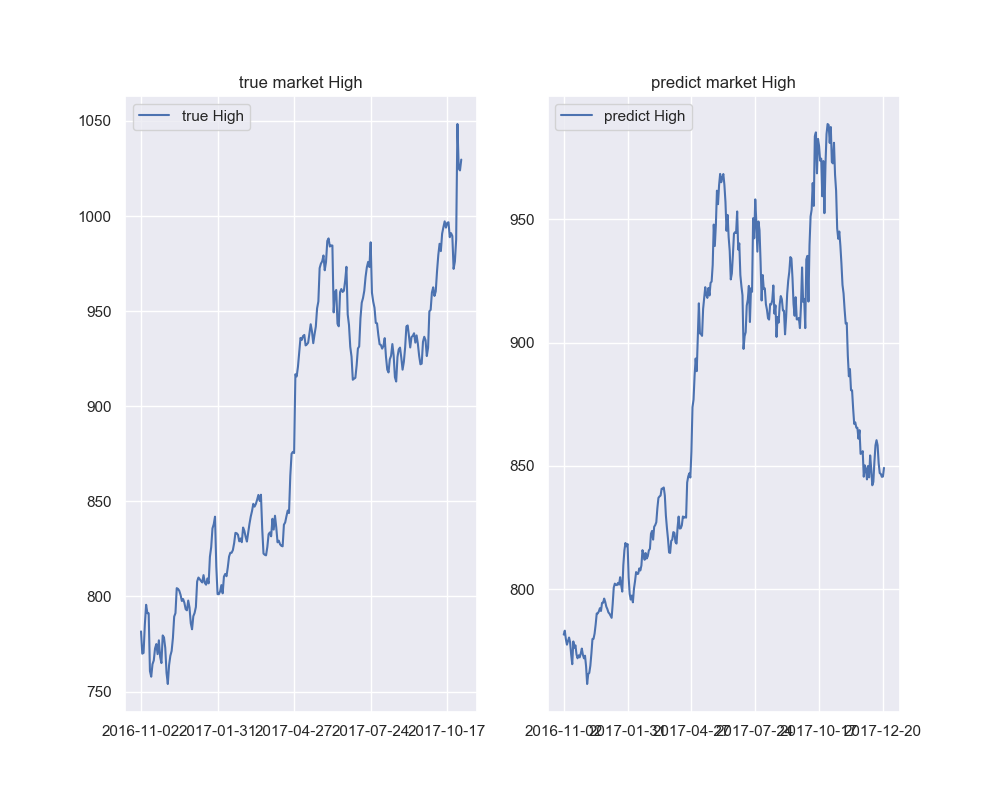

In [28]:
fig = plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, column_index], label = f'true {column_name}')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title(f'true market {column_name}')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, column_index], 0.5), label = f'predict {column_name}')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title(f'predict market {column_name}')
plt.show()

import config
import pandas as pd

def save_csv(nparr, prefix, columns):
    # , columns=columns
    df = pd.DataFrame.from_records(nparr)
    df.columns = columns
    df.to_csv(f"{prefix}_lstm_luong.csv")
    
save_csv(df, 'hist', columns=['Date','Open','High','Low','Close','Adj Close','Volume'])
save_csv(df_log, 'pred', columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    